
#**Twitter US Airline Sentiment**


## **Context:**

Twitter possesses 330 million monthly active users, which allows businesses to reach a broad population and connect with customers without intermediaries. On the other hand, there’s so much information that it’s difficult for brands to quickly detect negative social mentions that could harm their business.
That's why sentiment analysis/classification, which involves monitoring emotions in conversations on social media platforms, has become a key strategy in social media marketing.  Listening to how customers feel about the product/service on Twitter allows companies to understand their audience, keep on top of what’s being said about their brand and their competitors, and discover new trends in the industry.


## **Data Summary:**

This will be a sentiment analysis regarding the problems of each major U.S. airline. Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as "late flight" or "rude service").


This type of project is quite interesting as it sheds light on how good or bad each US airline is overall regarding their customer service and the quality of the flight experience for passengers.  The analysis of the data could help to make an informed choice on which airline to fly with.


Install required libraries:

In [ ]:
#uncomment the below two lines to install spacy and download the language model
!pip install spacy
!python -m spacy download en_core_web_sm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
2022-11-16 23:57:13.172111: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 17.9 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
!pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install vaderSentiment    # Install vader sentiment package

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install textblob   # Install textblob package

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive

import re, string, unicodedata                          # Import Regex, string and unicodedata.
import contractions                                     # Import contractions library.
from bs4 import BeautifulSoup                           # Beautiful soup is a parsing library that can use different parsers.

import numpy as np                                      # Import numpy.
import pandas as pd                                     # Import pandas.
import nltk                                             # Import Natural Language Tool-Kit.
import spacy

# Download Stopwords.
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

from nltk.corpus import stopwords                       # Import stopwords.
from nltk.tokenize import word_tokenize, sent_tokenize  # Import Tokenizer.
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import PorterStemmer,LancasterStemmer
from nltk.stem.wordnet import WordNetLemmatizer         # Import Lemmatizer.
import matplotlib.pyplot as plt                         
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer          #For Bag of words
from sklearn.feature_extraction.text import TfidfVectorizer          #For TF-IDF

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold , StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier       # Import Random forest Classifier
from sklearn.model_selection import cross_val_score  
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    plot_confusion_matrix,
    classification_report
)

from wordcloud import WordCloud,STOPWORDS

# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Function Definitions:

In [ ]:
# check the missing values for all the columns
def return_missing_values(data_frame):
    missing_values = data_frame.isnull().sum()
    missing_values = missing_values[missing_values>0]
    missing_values.sort_values(inplace=True)
    return missing_values

#plot the count of missing values in every column 
def plot_missing_values(data_frame):
    missing_values = return_missing_values(data_frame)
    missing_values = missing_values.to_frame()
    missing_values.columns = ['count']
    missing_values.index.names = ['Name']
    missing_values['Name'] = missing_values.index
    sns.set(style='darkgrid')
    sns.barplot(x='Name', y='count', data=missing_values)
    plt.title('Bar plot for Null Values in each column')
    plt.xticks(rotation=90)
    plt.show()

In [ ]:
#get the unique values of every column
def return_unique_values(data_frame):
    unique_dataframe = pd.DataFrame()
    unique_dataframe['Features'] = data_frame.columns
    uniques = []
    for col in data_frame.columns:
        u = data_frame[col].nunique()
        uniques.append(u)
    unique_dataframe['Uniques'] = uniques
    return unique_dataframe

In [ ]:
# function to create labeled barplots
def labeled_barplot(data, feature,  title, pallet='tab20',perc=True, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(16, 4))
    else:
        plt.figure(figsize=(16, 4))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data[feature],
        palette=pallet,
        order=data[feature].value_counts().index[:20],
    )
    ax.set_title('Distribution of {}'.format(title))

    for p in ax.patches:
        if perc == True:
            label = "{:1.2f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

Text pre-processing functions:

In [ ]:
#remove the html tags
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")                    
    return soup.get_text()

#expand the contractions
def replace_contractions(text):
    """Replace contractions in string of text"""
    return contractions.fix(text)

#remove the numericals present in the text
def remove_numbers(text):
  text = re.sub(r'\d+', '', text)
  return text

# remove the url's present in the text
def remove_url(text): 
    text = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','',text)
    return text

# remove the mentions in the tweets
def remove_mention(text):
    text = re.sub(r'@\w+','',text)
    return text

# remove accented characters
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text
#remove_accented_chars('Sómě Áccěntěd těxt')

#remove special characters
def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text
# remove_special_characters("Well this was fun! What do you think? 123#@!",remove_digits=True)

#lemmatization
#nlp = spacy.load('en_core_web_sm', parse=True, tag=True, entity=True)
nlp = spacy.load('en_core_web_sm')

def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text
#lemmatize_text("My system keeps crashing! his crashed yesterday, ours crashes daily")



Initialize the stopwords and the lemmatizer for the text processing functions below.

In [ ]:
stopwords = stopwords.words('english')
stopwords = list(set(stopwords)) 
lemmatizer = WordNetLemmatizer()

In [ ]:
#remove the non-ASCII characters
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

# convert all characters to lowercase
def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

# Remove the hashtags
def remove_hash(text):
   """Remove hashtags from list of tokenized words"""
   new_words = []
   for word in words:
     new_word = re.sub(r'#\w+','',word)
     if new_word != '':
       new_words.append(new_word)
   return new_words

# Remove the punctuations
def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

# Remove the stop words
def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords:
            new_words.append(word)
    return new_words

# lemmatize the words
def lemmatize_list(words):
    new_words = []
    for word in words:
      new_words.append(lemmatizer.lemmatize(word, pos='v'))
    return new_words


Custom confusion matrix function

In [ ]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    
    Example:

    labels = [‘True Neg’,’False Pos’,’False Neg’,’True Pos’]
    categories = [‘Zero’, ‘One’]
    make_confusion_matrix(cf_matrix, 
                          group_names=labels,
                          categories=categories, 
                          cmap=’binary’)

    '''

    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False

    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

Function to display top features and word cloud.

In [ ]:
def display_top_features(vectorizer,classifier, numfeatures = 40): # zzz
    top_features = []
    feature_names = vectorizer.get_feature_names()
    c = sorted(zip(classifier.feature_importances_, feature_names))
    top = c[:-(numfeatures + 1):-1]
    print("Importance_Value\tFeature")
    print("="*32)
    for (c, f) in top:
        print("%.4f\t\t\t%-15s" % (c, f))
        top_features.append(f)
    
    print(" ") 

    wordcloud = WordCloud(background_color="black",colormap='viridis',width=2000, height=1000).generate(" ".join(top_features))
    
    # Display the generated image:
    wc_title = 'Top ' + str(numfeatures) + ' Features WordCloud'
    fig = plt.figure(figsize=(10,15))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.figure(1, figsize=(14, 11), frameon='equal')
    plt.title(wc_title, fontsize=25)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()


Mount the Google drive:

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Read the data source:

In [ ]:
data=pd.read_csv('/content/drive/My Drive/Colab Notebooks/Python/Introduction To Natural Language Processing/Project9/Tweets.csv')

Get the shape of the data:

In [ ]:
data.shape                                               # print shape of data.

(14640, 15)

Data source has 14640 records with 15 features.

Display the 1st five rows:


In [ ]:
data.head()                                              # Print first 5 rows of data.

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


# Exploratory Data Analysis:

Display information on all columns in the dataframe

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

Display basic statistical details.

In [ ]:
data.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
tweet_id,14640.0,NaN,NaN,NaN,569218351767499200.0,779111158481835.875,567588278875213824.0,568559178101439488.0,569477857923110912.0,569890473289000960.0,570310600460525568.0
airline_sentiment,14640,3,negative,9178,NaN,NaN,NaN,NaN,NaN,NaN,NaN
airline_sentiment_confidence,14640.0,NaN,NaN,NaN,0.900169,0.16283,0.335,0.6923,1.0,1.0,1.0
negativereason,9178,10,Customer Service Issue,2910,NaN,NaN,NaN,NaN,NaN,NaN,NaN
negativereason_confidence,10522.0,NaN,NaN,NaN,0.638298,0.33044,0.0,0.3606,0.6706,1.0,1.0
airline,14640,6,United,3822,NaN,NaN,NaN,NaN,NaN,NaN,NaN
airline_sentiment_gold,40,3,negative,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN
name,14640,7701,JetBlueNews,63,NaN,NaN,NaN,NaN,NaN,NaN,NaN
negativereason_gold,32,13,Customer Service Issue,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
retweet_count,14640.0,NaN,NaN,NaN,0.08265,0.745778,0.0,0.0,0.0,0.0,44.0


Check for null values.

In [ ]:
data.isnull().sum(axis=0)          

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

Visualization of missing value using a heatmap

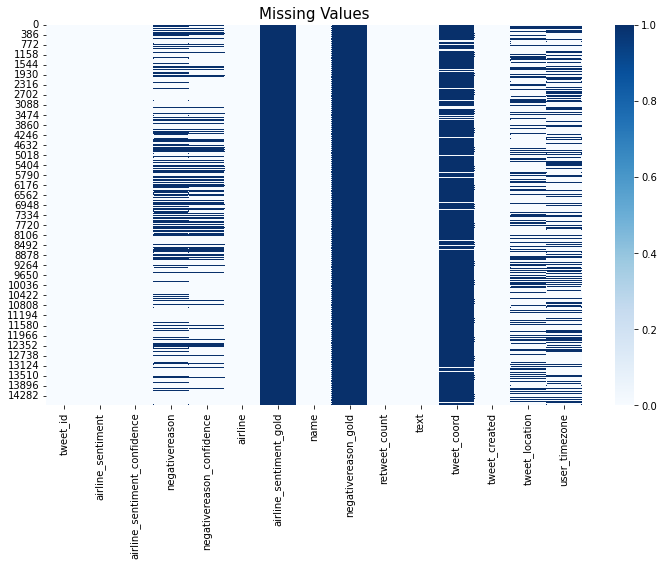

In [ ]:
plt.figure(figsize=(12,7))
sns.heatmap(data.isnull(), cmap = "Blues")                   
plt.title("Missing Values", fontsize = 15)
plt.show()

Get the counts of missing values in every column of the dataframe

In [ ]:
return_missing_values(data)

negativereason_confidence     4118
tweet_location                4733
user_timezone                 4820
negativereason                5462
tweet_coord                  13621
airline_sentiment_gold       14600
negativereason_gold          14608
dtype: int64

Plot the count of missing values.

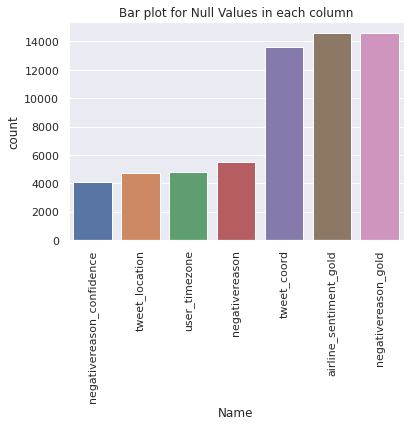

In [ ]:
plot_missing_values(data)

Most data is missing from the 'tweet_coord', 'airline_sentiment_gold' & 'negativereason_gold' features.

Seven features do have null values but 'text' and 'airline_sentiment' do not.   As these are the key features, no action needs to be taken regarding the other features with null data.

Get the unique values count from the dataframe.

In [ ]:
unidf = return_unique_values(data)
print(unidf)

                        Features  Uniques
0                       tweet_id    14485
1              airline_sentiment        3
2   airline_sentiment_confidence     1023
3                 negativereason       10
4      negativereason_confidence     1410
5                        airline        6
6         airline_sentiment_gold        3
7                           name     7701
8            negativereason_gold       13
9                  retweet_count       18
10                          text    14427
11                   tweet_coord      832
12                 tweet_created    14247
13                tweet_location     3081
14                 user_timezone       85


Plot the count of unique values for all features.

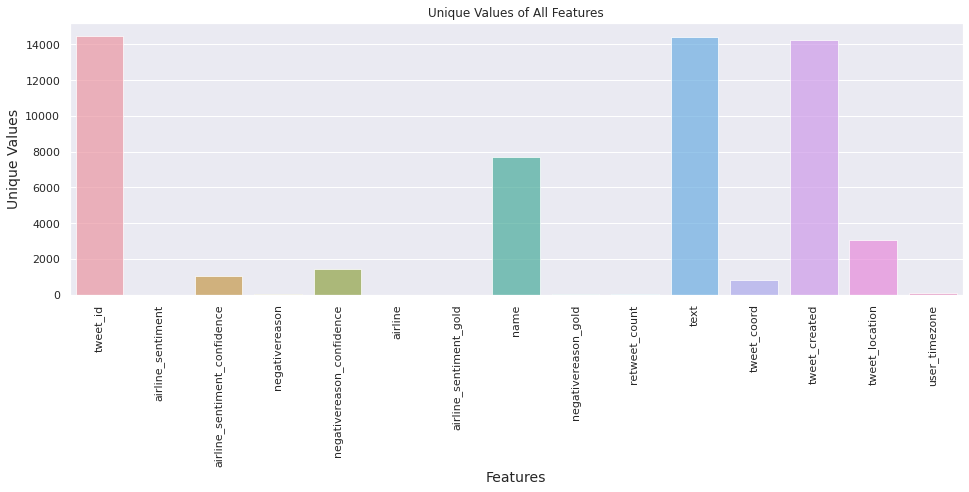

In [ ]:
f, ax = plt.subplots(1,1, figsize=(16,5))
sns.barplot(x=unidf['Features'], y=unidf['Uniques'], alpha=0.7)
plt.title('Unique Values of All Features')
plt.ylabel('Unique Values', fontsize=14)
plt.xlabel('Features', fontsize=14)
plt.xticks(rotation=90)
plt.show()

Top 20 time zones based on the number of tweets

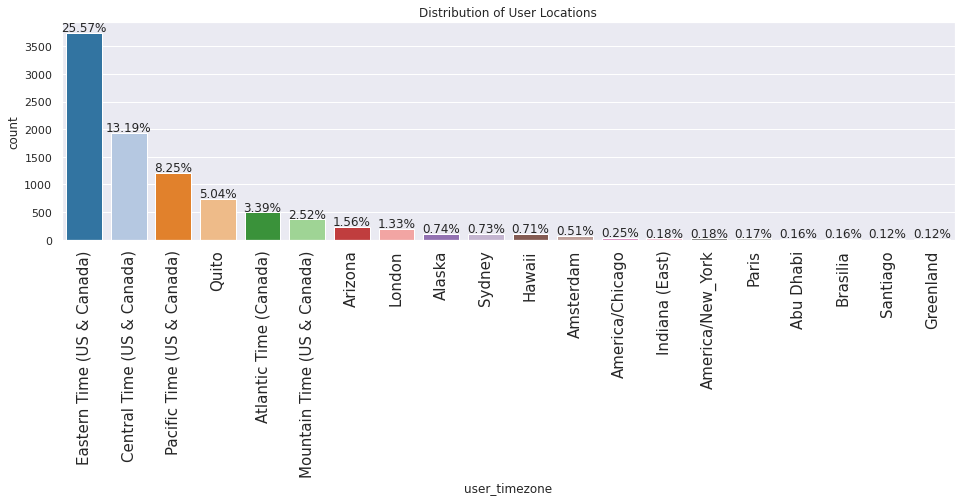

In [ ]:
labeled_barplot(data, 'user_timezone', 'User Locations')

Over 25% of tweets come from the Eastern Time zone.

Plot of the distribution of all tweets by airline

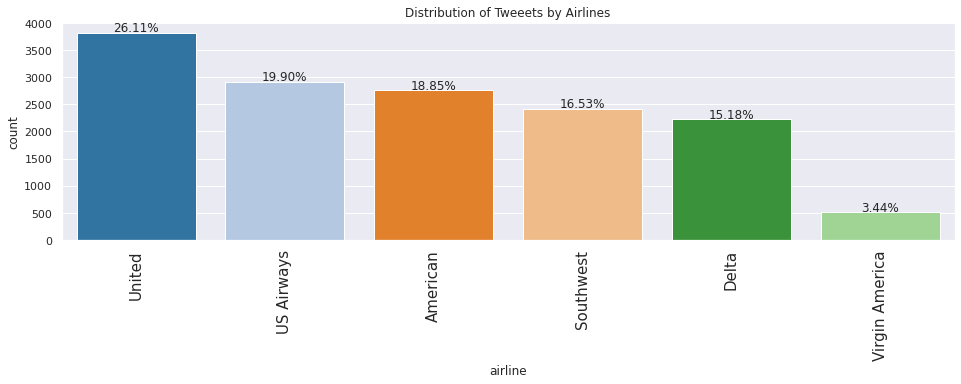

In [ ]:
labeled_barplot(data, 'airline', 'Tweeets by Airlines')

United and US Airways garner the most tweeted.  Virgin America has the least tweets.

Plot the distribution of sentiment across all the tweets. 

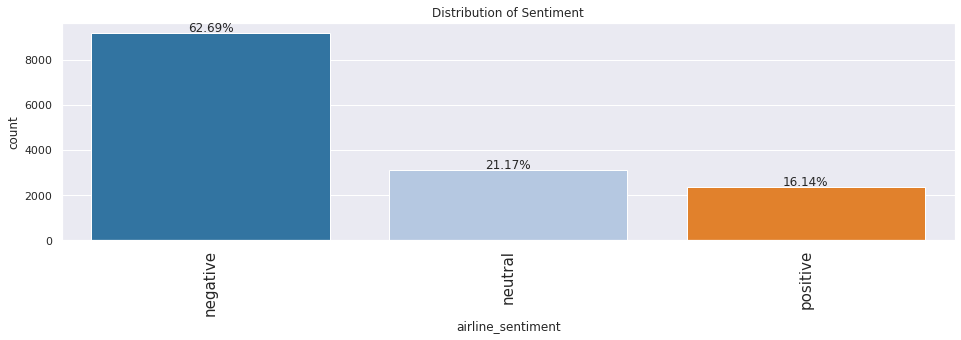

In [ ]:
labeled_barplot(data, 'airline_sentiment', 'Sentiment')

Over 62% of the tweets are negative.  However, people love to complain more than they like to praise.

Plot the distribution of sentiment of tweets for each airline

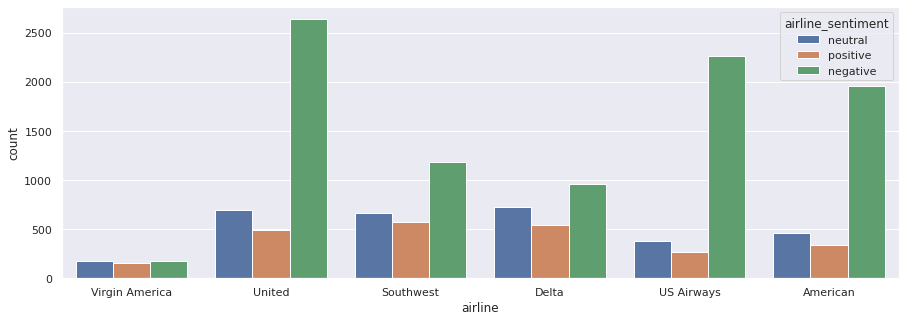

In [ ]:
plt.figure(figsize=(15,5))
sns.countplot(data['airline'],hue=data['airline_sentiment'])
plt.show()

United leads for negative tweets, followed by US Airways and American.

For positive tweets, Southwest leads followed by Delta and United.

Plot the distribution of all the negative reasons

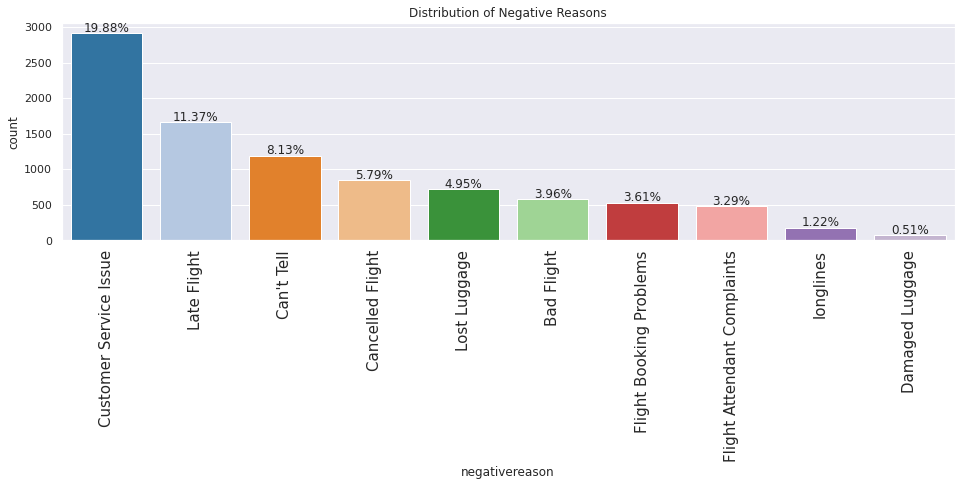

In [ ]:
labeled_barplot(data, 'negativereason', 'Negative Reasons')

Customer service concerns lead followed by the flight being late.

Plot the distribution of all the negative reasons by airline

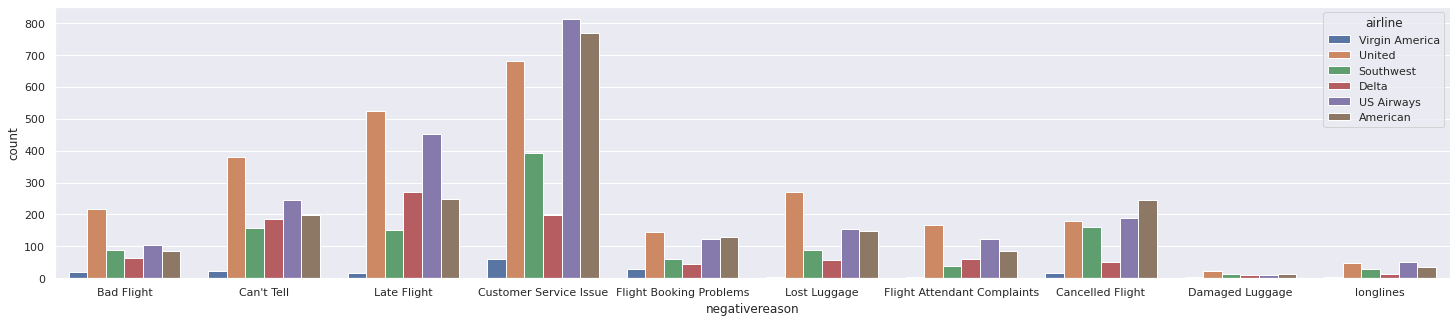

In [ ]:
plt.figure(figsize=(25,5))
sns.countplot(data['negativereason'],hue=data['airline'])
plt.show()

US Airways, American, and United lead for negative 'Customer Service' issues.   

United, US Airways, and Delta are the top 3 for 'late flight' complaints. 

 Plot the word cloud graph of tweets for negative sentiment

In [ ]:
negative_tweets=data[data['airline_sentiment']=='negative']
words = ' '.join(negative_tweets['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])

In [ ]:
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)

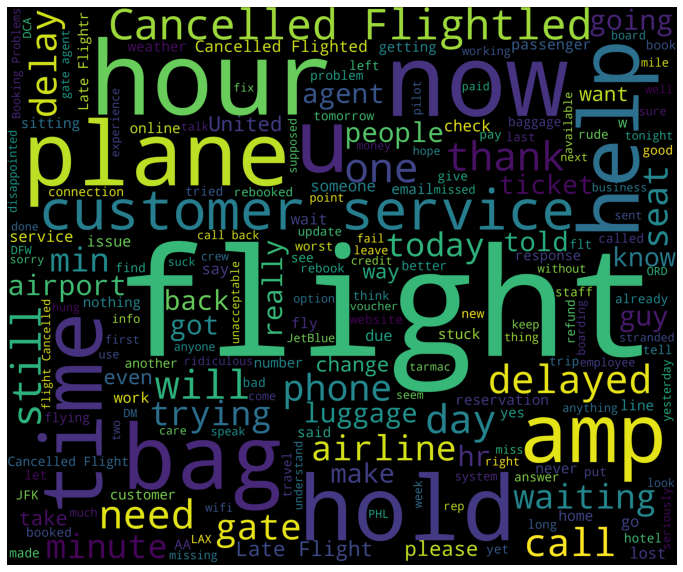

In [ ]:
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

A lot of the words shown such as 'customer service', 'cancelled', 'delayed', and 'waiting' have a correlation to the top negative reasons provided by customer feedback.

 Plot the word cloud graph of tweets for positive sentiment

In [ ]:
positive_tweets=data[data['airline_sentiment']=='positive']
words = ' '.join(positive_tweets['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])

In [ ]:
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)

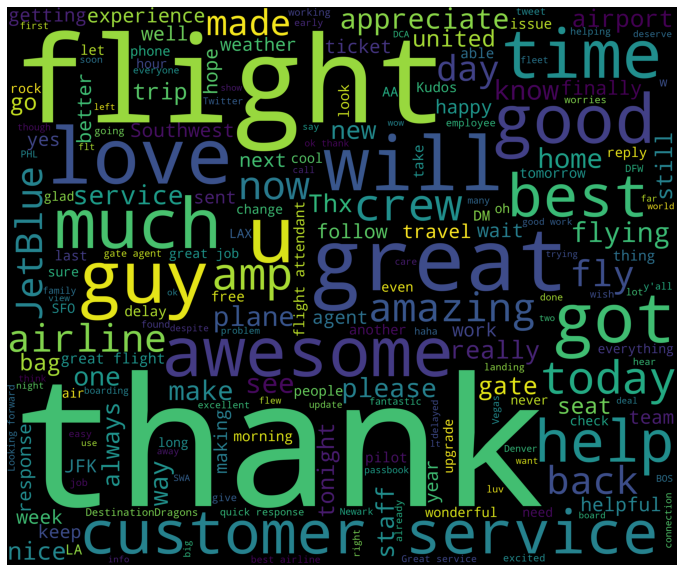

In [ ]:
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Customers are appreciative and offer praise for helpful staff and when the flight goes well.

### Understanding of Data Columns: Drop all other columns except “text” and “airline_sentiment”

In [ ]:
droprows = ['tweet_id','airline_sentiment_confidence','negativereason','negativereason_confidence','airline','airline_sentiment_gold','name','negativereason_gold','retweet_count','tweet_coord','tweet_created','tweet_location','user_timezone']

In [ ]:
data.drop(columns=droprows, axis=1, inplace=True)

Display the 1st few rows.

In [ ]:
pd.set_option('display.max_colwidth', None) # Display full dataframe information (Non-truncated text column.)
data.head()                                 

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.
2,neutral,@VirginAmerica I didn't today... Must mean I need to take another trip!
3,negative,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse"
4,negative,@VirginAmerica and it's a really big bad thing about it


Check the shape of the data.

In [ ]:
data.shape

(14640, 2)

We still have all the records we started with from the source file.

### Data Pre-Processing

Remove the html tags

In [ ]:
data['text'] = data['text'].apply(lambda x: strip_html(x))

Fix the contractions

In [ ]:
data['text'] = data['text'].apply(lambda x:  replace_contractions(x))

Remove the numericals present in the text

In [ ]:
data['text'] = data['text'].apply(lambda x: remove_numbers(x))

Remove the url's present in the text

In [ ]:
data['text'] = data['text'].apply(lambda x: remove_url(x))

Remove the mentions in the tweets

In [ ]:
data['text'] = data['text'].apply(lambda x: remove_mention(x))

In [ ]:
data.head()

,airline_sentiment,text
0,neutral,What said.
1,positive,plus you have added commercials to the experience... tacky.
2,neutral,I did not today... Must mean I need to take another trip!
3,negative,"it is really aggressive to blast obnoxious ""entertainment"" in your guests' faces & they have little recourse"
4,negative,and it is a really big bad thing about it


Tokenize the text.

In [ ]:
data['text'] = data.apply(lambda row: nltk.word_tokenize(row['text']), axis=1)

In [ ]:
data.head()

,airline_sentiment,text
0,neutral,"[What, said, .]"
1,positive,"[plus, you, have, added, commercials, to, the, experience, ..., tacky, .]"
2,neutral,"[I, did, not, today, ..., Must, mean, I, need, to, take, another, trip, !]"
3,negative,"[it, is, really, aggressive, to, blast, obnoxious, ``, entertainment, '', in, your, guests, ', faces, &, they, have, little, recourse]"
4,negative,"[and, it, is, a, really, big, bad, thing, about, it]"


Remove the non-ASCII characters

In [ ]:
data['text'] = data.apply(lambda row: remove_non_ascii(row['text']), axis=1)

Convert all characters to lowercase

In [ ]:
data['text'] = data.apply(lambda row: to_lowercase(row['text']), axis=1)

 Remove the punctuations

In [ ]:
data['text'] = data.apply(lambda row: remove_punctuation(row['text']), axis=1)

Remove the stop words

In [ ]:
data['text'] = data.apply(lambda row: remove_stopwords(row['text']), axis=1)

 Lemmatize the words

In [ ]:
data['text'] = data.apply(lambda row: lemmatize_list(row['text']), axis=1)

In [ ]:
data.head()

,airline_sentiment,text
0,neutral,[say]
1,positive,"[plus, add, commercials, experience, tacky]"
2,neutral,"[today, must, mean, need, take, another, trip]"
3,negative,"[really, aggressive, blast, obnoxious, entertainment, guests, face, little, recourse]"
4,negative,"[really, big, bad, thing]"


Join the words in the list to convert back to text string in the data frame.

In [ ]:
data['text'] = data.apply(lambda row: (' '.join((row['text']))), axis=1)

Print the first 5 rows of data after pre-processing.

In [ ]:
data.head()

,airline_sentiment,text
0,neutral,say
1,positive,plus add commercials experience tacky
2,neutral,today must mean need take another trip
3,negative,really aggressive blast obnoxious entertainment guests face little recourse
4,negative,really big bad thing


### Pre-processing completed.

## Vectorization

In order to perform machine learning on the tweets (text), we need to transform that data into numerical vectors.

Bag Of Words (CountVectorizer)

### **Bag of Words(BoW) Model (CountVectorizer)**
      
Using this model, a dictionary is created that contains the set of all unique words from the tweets. The frequency of the words are counted.  An encoded vector is returned with a length of the vocabulary and an integer count for the number of times each word appeared in the text.

Vectorize the text data and convert to an array

In [ ]:
cv1 = CountVectorizer() 
data_features = cv1.fit_transform(data['text'])
data_features = data_features.toarray()                        

Display the shape of the new data features array.

In [ ]:
data_features.shape

(14640, 9994)

Create the variables to be used by the training and testing set. 

In [ ]:
X = data_features
y = data.airline_sentiment

Split the data into training and testing sets.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

 Cross-validate the model performance. Find the optimal number of base learners using k-fold CV.

In [ ]:
base_ln = np.arange(100,400,100).tolist()
base_ln

[100, 200, 300]

In [ ]:
cv_scores = []
for b in base_ln:
    clf = RandomForestClassifier(n_estimators = b)
    scores = cross_val_score(clf, X_train, y_train, cv = 5, scoring = 'accuracy')
    cv_scores.append(scores.mean())

Plot the error as k increases.  We need to determine the optimal value for the number of estimators which produces the smallest error.

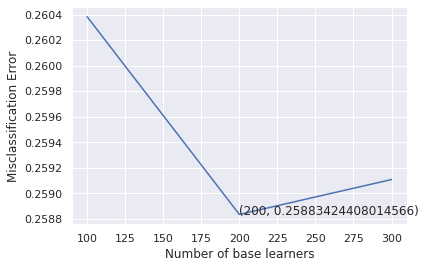

In [ ]:
error = [1 - x for x in cv_scores] # Error corresponds to each nu of estimator
optimal_learners = base_ln[error.index(min(error))]  # Selection of optimal value for n_estimator which corresponds to a minimum error.
plt.plot(base_ln, error) # Plot between each nu of estimator and misclassification error                                          
xy = (optimal_learners, min(error))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.xlabel("Number of base learners")
plt.ylabel("Misclassification Error")
plt.show()

Training the best model and calculating accuracy on test data.

In [ ]:
clf = RandomForestClassifier(n_estimators = optimal_learners)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)
count_vectorizer_predicted = clf.predict(X_test)
print(classification_report(y_test ,count_vectorizer_predicted , target_names = ['Negative','Neutral','Positive']))
print("Accuracy of the model is : ",accuracy_score(y_test,count_vectorizer_predicted))

              precision    recall  f1-score   support

    Negative       0.86      0.90      0.88      2627
     Neutral       0.52      0.47      0.49       577
    Positive       0.71      0.61      0.65       456

    accuracy                           0.80      3660
   macro avg       0.70      0.66      0.68      3660
weighted avg       0.79      0.80      0.79      3660

Accuracy of the model is :  0.796448087431694


Generate a confusion matirx to get an idea of how the distribution of the prediction is among all the classes.

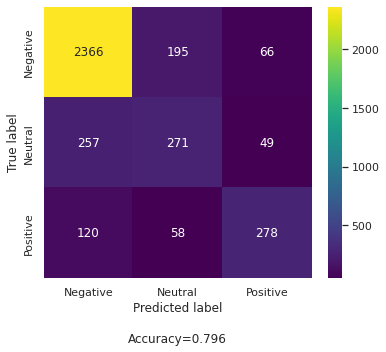

In [ ]:
cmlabels = ['True Neg','False Pos','False Neg','True Pos']
class_names = ['Negative','Neutral','Positive']

model1_cm = confusion_matrix(y_test, count_vectorizer_predicted)
make_confusion_matrix(model1_cm,group_names=cmlabels,categories=class_names,figsize=(6,5),percent=False,cmap='viridis')


Print the top 40 features and plot their word cloud.

Importance_Value	Feature
0.0560			thank          
0.0116			delay          
0.0110			great          
0.0093			flight         
0.0078			love           
0.0070			hold           
0.0068			hours          
0.0068			awesome        
0.0064			bag            
0.0054			get            
0.0053			hour           
0.0051			cancel         
0.0043			best           
0.0042			amaze          
0.0041			service        
0.0041			time           
0.0041			wait           
0.0040			worst          
0.0039			plane          
0.0039			customer       
0.0037			still          
0.0037			fleek          
0.0036			fly            
0.0035			call           
0.0035			fleet          
0.0035			make           
0.0035			please         
0.0034			lose           
0.0033			never          
0.0033			help           
0.0032			would          
0.0031			try            
0.0031			say            
0.0031			luggage        
0.0030			go             
0.0030			tell           
0.0030			need           
0.0029			dm             
0.0029			miss           


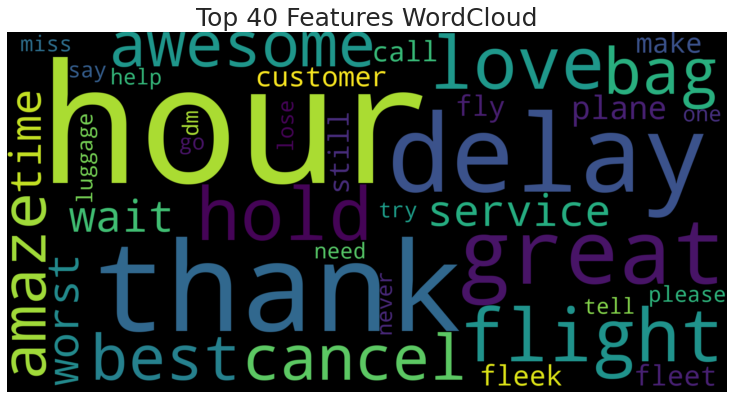

In [ ]:
display_top_features(cv1,clf,40) # zzz

### TF-IDF

**Term Frequency -  Inverse Document Frequency:**  This is a statistic used to identify how important a word is in a document. It returns lower weights for the most frequent words, and higher weights to less frequent words.


Create a TfidfVectorizer to convert text data to numbers.

In [ ]:
#tfidf_vect = TfidfVectorizer(max_features=500)
tfidf_vect = TfidfVectorizer()
data_features = tfidf_vect.fit_transform(data['text'])
data_features = data_features.toarray()


Display the shape of the new data features array.

In [ ]:
data_features.shape

(14640, 9994)

Create the variables to be used by the training and testing set.

In [ ]:
X = data_features
y = data.airline_sentiment

Split data into training and testing set.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

 Cross-validate the model performance. Find the optimal number of base learners using k-fold CV

In [ ]:
base_ln = np.arange(100,400,100).tolist()
base_ln

[100, 200, 300]

In [ ]:
cv_scores = []
for b in base_ln:
    clf = RandomForestClassifier(n_estimators = b)
    scores = cross_val_score(clf, X_train, y_train, cv = 5, scoring = 'accuracy')
    cv_scores.append(scores.mean())

Plot the error as k increases.  We need to determine the optimal value for the number of estimators which produces the smallest error.

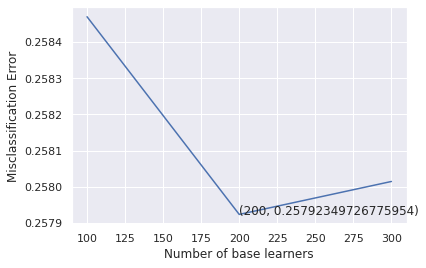

In [ ]:
error = [1 - x for x in cv_scores] # Error corresponds to each nu of estimator
optimal_learners = base_ln[error.index(min(error))] # Selection of optimal nu of n_estimator corresponds to minimum error.
plt.plot(base_ln, error) # Plot between each nu of estimator and misclassification error
xy = (optimal_learners, min(error))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.xlabel("Number of base learners")
plt.ylabel("Misclassification Error")
plt.show()

Training the best model and calculating accuracy on test data.

In [ ]:
clf2 = RandomForestClassifier(n_estimators = optimal_learners)
clf2.fit(X_train, y_train)
clf2.score(X_test, y_test)
tf_idf_predicted = clf2.predict(X_test)
print(classification_report(y_test , tf_idf_predicted , target_names = ['Negative','Neutral','Positive']))
print("Accuracy of the model is : ",accuracy_score(y_test,tf_idf_predicted))

              precision    recall  f1-score   support

    Negative       0.85      0.93      0.89      2627
     Neutral       0.60      0.45      0.51       577
    Positive       0.72      0.59      0.65       456

    accuracy                           0.81      3660
   macro avg       0.73      0.66      0.69      3660
weighted avg       0.80      0.81      0.80      3660

Accuracy of the model is :  0.8101092896174863


Generate a confusion matirx to get an idea of how the distribution of the prediction is among all the classes.

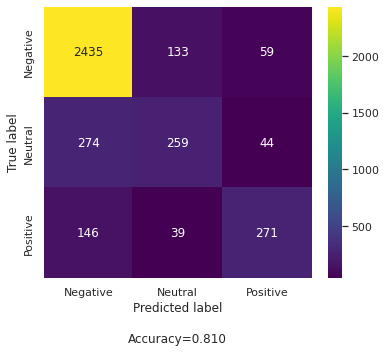

In [ ]:
model2_cm = confusion_matrix(y_test, tf_idf_predicted)
make_confusion_matrix(model2_cm,group_names=cmlabels,categories=class_names,figsize=(6,5),percent=False,cmap='viridis')


Print the top 40 features and plot their word cloud.

Importance_Value	Feature
0.0581			thank          
0.0121			great          
0.0120			delay          
0.0118			flight         
0.0085			love           
0.0068			hold           
0.0067			awesome        
0.0067			get            
0.0064			hours          
0.0063			bag            
0.0063			cancel         
0.0055			hour           
0.0051			best           
0.0051			fleet          
0.0051			service        
0.0049			time           
0.0047			amaze          
0.0046			wait           
0.0045			please         
0.0045			fly            
0.0045			plane          
0.0044			call           
0.0044			follow         
0.0042			dm             
0.0042			fleek          
0.0041			make           
0.0041			good           
0.0040			help           
0.0040			lose           
0.0039			customer       
0.0039			send           
0.0038			much           
0.0038			still          
0.0037			worst          
0.0036			never          
0.0036			would          
0.0035			say            
0.0034			appreciate     
0.0034			go             


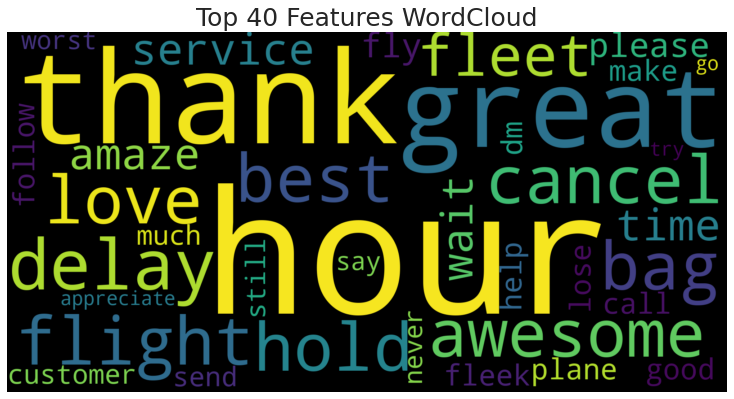

In [ ]:
display_top_features(tfidf_vect,clf2,40)

Evaluation Of Models

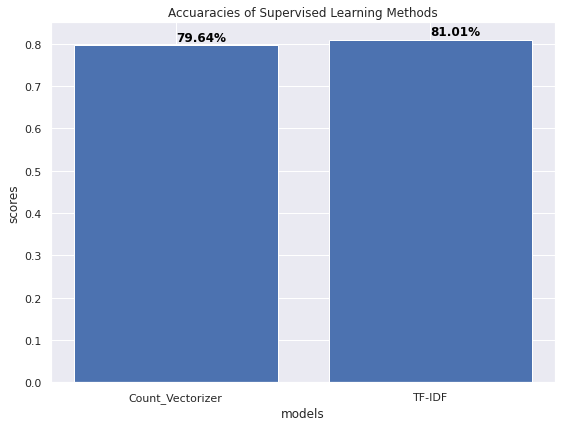

In [ ]:
#create bar plot to compare the accuaracies of Count Vectorizer and TF-IDF
fig = plt.figure(figsize=(7,5))
ax = fig.add_axes([0,0,1,1])
subjects = ['Count_Vectorizer', 'TF-IDF']

# calculation accuracies of Count Vectorizer and TF-IDF using accuracy_score metrics
scores = [accuracy_score(y_test,count_vectorizer_predicted),accuracy_score(y_test,tf_idf_predicted)]
ax.bar(subjects,scores)
ax.set_ylabel('scores',fontsize= 12)    # y axis label
ax.set_xlabel('models',fontsize= 12)    # x axis label
ax.set_title('Accuaracies of Supervised Learning Methods')  # tittle
for i, v in enumerate(scores):
    ax.text( i ,v+0.01, '{:.2f}%'.format(100*v), color='black', fontweight='bold')     
    plt.savefig('barplot_1.png',dpi=100, format='png', bbox_inches='tight')
plt.show()

The models are very close in their performance with TF-IDF having slightly higher accuracy.

# **Conclusion:**

- We used a Twitter dataset containing customer feedback regarding the problems reported by major US airlines.
- The goal was to perform a sentiment analysis on that data and build models for text-classification of the customer's responses.
- We performed the required pre-processing of the text data using various techniques such as:

    * Replacing contractions
    * Removal of HTML tags, numericals, URLs, & mentions
    * Word Tokenization
    * Removal of non-ASCII characters, punctuation, stop words
    * Conversion to lowercase
    * Word lemmatization

- The pre-processed data was converted to numerical data using the Bag of Words (CountVectorizer) and TF-IDF (TfidfVectorizer) feature extraction techniques.  This allowed the data to be used in the models.
- We trained each model using the vectorized data and cross validated the model performance. 
- An accuracy score and a confusion matrix were generated for each model so as to evaluate performances.
- The top 40 features were printed and a word cloud plot was displayed for both types of vectorization.
- Both models performed well with the TF-IDF vectorizer having slightly better accurary.
